# Dimensionality Reduction using RTD-AE on Single Cell RNA data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os
import requests

import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from src.autoencoder import AutoEncoder
from src.utils import *
from src.rtd import RTDLoss, MinMaxRTDLoss
from src.top_ae import TopologicallyRegularizedAutoencoder

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from collections import defaultdict

from tqdm.notebook import tqdm

## Downloads

In [6]:
# URL for the Tabula Muris FACS zip file
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE93374&format=file&file=GSE93374%5Fcell%5Fmetadata%2Etxt%2Egz"

# File path where to save
output_file = "GSE93374_cell_metadata.txt.gz"

# Download the file
if not os.path.exists(output_file):
    print("Downloading dataset...")
    response = requests.get(url)
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print(f"Dataset saved to {output_file}")
else:
    print(f"Dataset already downloaded: {output_file}")


Dataset saved to GSE93374_cell_metadata.txt.gz


In [ ]:
# URL for the Tabula Muris metadata csv file
url = "https://figshare.com/ndownloader/files/10038310"

# File path where to save
output_file = "data/TabulaMuris/metadata_FACS.csv"

# Download the file
if not os.path.exists(output_file):
    print("Downloading dataset...")
    response = requests.get(url)
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print(f"Dataset saved to {output_file}")
else:
    print(f"Dataset already downloaded: {output_file}")



KeyboardInterrupt



In [ ]:
# URL for the Tabula Muris annotations csv file
url = "https://figshare.com/ndownloader/files/10039267"

# File path where to save
output_file = "data/TabulaMuris/annotations_FACS.csv"

# Download the file
if not os.path.exists(output_file):
    print("Downloading dataset...")
    response = requests.get(url)
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print(f"Dataset saved to {output_file}")
else:
    print(f"Dataset already downloaded: {output_file}")


## Data preprocessing

In [2]:
count_dataframe = pd.read_csv("data/TabulaMuris/contents/brain_counts.csv", index_col=0)
metadata_dataframe = pd.read_csv("data/TabulaMuris/contents/brain_metadata.csv", index_col=0)

In [3]:
count_dataframe

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,0
A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,0,...,0,0,0,0,0,195,0,0,113,0
A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,14,...,0,0,0,0,125,0,1,0,0,0
A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,0,...,0,0,0,81,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA000926.3_9_M.1.1,0,111,0,0,32,55,63,0,0,0,...,0,0,0,0,4,12,64,0,3,0
P9.MAA000930.3_8_M.1.1,0,223,2,0,0,49,0,0,0,0,...,0,0,0,10,1,50,2,0,0,0
P9.MAA000932.3_11_M.1.1,0,135,41,0,0,0,0,0,0,0,...,0,19,0,0,18,0,0,0,45,0
P9.MAA000935.3_8_M.1.1,0,129,54,0,0,209,0,0,0,0,...,0,0,0,1,0,0,0,0,57,0


In [4]:
metadata_dataframe

,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode
cell,,,,,
A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290
A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728
A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560
A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564
A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923
...,...,...,...,...,...
P9.MAA000926.3_9_M.1.1,oligodendrocyte precursor cell,Cortex,M,3_9_M,MAA000926
P9.MAA000930.3_8_M.1.1,astrocyte,Cortex,M,3_8_M,MAA000930
P9.MAA000932.3_11_M.1.1,endothelial cell,Hippocampus,M,3_11_M,MAA000932


In [5]:
metadata_dataframe['cell_ontology_class'].value_counts()

cell_ontology_class
oligodendrocyte                   1574
endothelial cell                   715
astrocyte                          432
neuron                             281
oligodendrocyte precursor cell     203
brain pericyte                     156
Bergmann glial cell                 40
Name: count, dtype: int64

In [6]:
y = metadata_dataframe["cell_ontology_class"]
y = y.astype('category').cat.codes
y = y.values
y

array([1, 1, 5, ..., 3, 5, 1], dtype=int8)

In [7]:
# count each value of y
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5, 6], dtype=int8),
 array([  40,  432,  156,  715,  281, 1574,  203]))

In [8]:
cat2class = {0: 'bergmann glial cell',
             1: 'astrocyte',
             2: 'brain pericyte',
             3: 'endothelial cell',
             4: 'neuron',
             5: 'oligodendrocyte',
             6: 'oligodendrocyte precursor cell'}

In [9]:
y.shape

(3401,)

In [10]:
X = count_dataframe.values
X.shape

(3401, 23433)

In [11]:
zero_columns = np.where(~X.any(axis=0))[0]
X = np.delete(X, zero_columns, axis=1)


In [12]:
X.shape

(3401, 20818)

In [13]:
X = (X - X.mean(axis=0)) / X.std(axis=0)
X

array([[-0.04392777, -0.21203353, -0.13537831, ..., -0.22462625,
        -0.04105318,  0.03144998],
       [-0.04392777, -0.53839162, -0.24401476, ..., -0.22462625,
        -0.04105318, -0.2693946 ],
       [-0.04392777,  0.37018929, -0.24401476, ..., -0.22462625,
        -0.04105318,  0.36015055],
       ...,
       [-0.04392777, -0.18592489,  0.03436614, ..., -0.22462625,
        -0.04105318, -0.01869078],
       [-0.04392777, -0.20159008,  0.12263325, ..., -0.22462625,
        -0.04105318,  0.04816357],
       [-0.04392777, -0.53578076, -0.24401476, ..., -0.22462625,
        -0.04105318, -0.2693946 ]])

## AE model preparation

In [14]:
config = {
    "dataset_name":"TabulaMuris_Brain_Neurons",
    "version":"batchsize_10",
    "model_name":"default",
    "max_epochs":100,
    "gpus":[0],
    "rtd_every_n_batches":1,
    "rtd_start_epoch":0,
    "rtd_l":1.0, # rtd loss 
    "n_runs":1, # number of runs for each model
    "card":50, # number of points on the persistence diagram
    "n_threads":50, # number of threads for parallel ripser computation of pers homology
    "latent_dim":2, # latent dimension (2 or 3 for vizualization purposes)
    "input_dim":X.shape[1], # input dimension
    "n_hidden_layers":2,
    "hidden_dim":100,
    "batch_size":10,
#     "width":80,
#     "heigth":80,
    "engine":"ripser",
    "is_sym":True,
    "lr":1e-4
#     'mode':'minimum',
#     'lp':1.0
}

In [24]:
def get_model(input_dim, latent_dim=2, n_hidden_layers=2, m_type='encoder', **kwargs):
    n = int(np.log2(input_dim))-1
    layers = []
    if m_type == 'encoder':
        in_dim = input_dim
        if input_dim  // 2 >= latent_dim:
            out_dim = input_dim // 2
        else:
            out_dim = input_dim
        for i in range(min(n, n_hidden_layers)):
            layers.extend([nn.Linear(in_dim, out_dim), nn.ReLU()])
            in_dim = out_dim
            if in_dim  // 2 >= latent_dim:
                out_dim = in_dim // 2
            else:
                out_dim = in_dim
        layers.extend([nn.Linear(in_dim, latent_dim)])
    elif m_type == 'decoder':
        in_dim = latent_dim
        out_dim = latent_dim * 2
        for i in range(min(n, n_hidden_layers)):
            layers.extend([nn.Linear(in_dim, out_dim), nn.ReLU()])
            in_dim = out_dim
            out_dim *= 2
        layers.extend([nn.Linear(in_dim, input_dim)])
    return nn.Sequential(*layers)

def get_list_of_models(**config):
    # define a list of models
    encoder = get_linear_model(
        m_type='encoder',
        **config
    )
    decoder = get_linear_model(
        m_type='decoder',
        **config
    )
    models = {
        'RTD_AutoEncoder':AutoEncoder(
            encoder = encoder,
            decoder = decoder,
            RTDLoss = RTDLoss(dim=1, lp=1.0,  **config), # only H1
            MSELoss = nn.MSELoss(),
            **config
        )
    }
    return models, encoder, decoder

In [25]:
def collate_with_matrix(samples):
    indicies, data, labels = zip(*samples)
    data, labels = torch.tensor(np.asarray(data)), torch.tensor(np.asarray(labels))
    if len(data.shape) > 2:
        dist_data = torch.flatten(data, start_dim=1)
    else:
        dist_data = data
    x_dist = torch.cdist(dist_data, dist_data, p=2) / np.sqrt(dist_data.shape[1])
#     x_dist = (x_dist + x_dist.T) / 2.0 # make symmetrical (cdist is prone to computational errors)
    return data, x_dist, labels

def collate_with_matrix_geodesic(samples):
    indicies, data, labels, dist_data = zip(*samples)
    data, labels = torch.tensor(np.asarray(data), dtype = torch.float32), torch.tensor(np.asarray(labels))
    x_dist = torch.tensor(np.asarray(dist_data)[:, indicies], dtype=torch.float32)
    return data, x_dist, labels

In [26]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

((2720, 20818), (681, 20818), (2720,), (681,))

In [28]:
scaler = FurthestScaler()
# scaler = None
flatten = True
geodesic = True

train = FromNumpyDataset(
    train_data, 
    train_labels, 
    geodesic=geodesic, 
    scaler=scaler, 
    flatten=flatten, 
    n_neighbors=2
)
print("Train done")
test = FromNumpyDataset(
    test_data, 
    test_labels, 
    geodesic=geodesic, 
    scaler = train.scaler,    
    flatten=flatten, 
    n_neighbors=2
)

N connected: 1
Train done
N connected: 1


In [29]:
train_loader = DataLoader(
    train, 
    batch_size=config["batch_size"], 
    num_workers=2, 
    collate_fn=collate_with_matrix_geodesic if geodesic else collate_with_matrix, 
    shuffle=True
)

val_loader = DataLoader(
    test,
    batch_size=config["batch_size"],
    num_workers=2,
    collate_fn=collate_with_matrix_geodesic if geodesic else collate_with_matrix,
)

## AE Training

In [30]:
def train_autoencoder(model, train_loader, val_loader=None, model_name='default', 
                      dataset_name='MNIST', gpus=[3], max_epochs=100, run=0, version=""):
    version = f"{dataset_name}_{model_name}_{version}_{run}"
    logger = pl.loggers.TensorBoardLogger(save_dir=os.getcwd(), name='lightning_logs', version=version)
    trainer = pl.Trainer(
        logger=logger, 
        devices=gpus, 
        max_epochs=max_epochs, 
        log_every_n_steps=1, 
        num_sanity_val_steps=0
    )
    trainer.fit(model, train_loader, val_loader)
    return model

def dump_figures(figures, dataset_name, version):
    for model_name in figures:
        figures[model_name].savefig(f'results/{dataset_name}/{model_name}_{version}.png')

def train_models(train_loader, val_loader, dataset_name="", max_epochs=1, gpus=[0], n_neighbors=[1], n_runs=1, version='', **kwargs):
    models, encoder, decoder = get_list_of_models(**kwargs)
    for model_name in tqdm(models, desc=f"Training models"):
        if 'AutoEncoder' in model_name: # train an autoencoder
            models[model_name] = train_autoencoder(
                models[model_name], 
                train_loader, 
                val_loader, 
                model_name, 
                dataset_name,
                gpus,
                max_epochs,
                0,
                version
            )
        else: # umap / pca / t-sne (sklearn interface)
            train_latent = models[model_name].fit_transform(train_loader.dataset.data)
        # measure training time
    return encoder, decoder, models

In [ ]:
encoder, decoder, trained_models = train_models(train_loader, val_loader, **config)

Training models:   0%|          | 0/1 [00:00<?, ?it/s]

/users/eleves-b/2021/pierre.aguie/.local/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/eleves-b/2021/pierre.aguie/.local/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 12GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | encoder      | Seq

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [99]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 331273), started 6 days, 9:25:59 ago. (Use '!kill 331273' to kill it.)

## Visualisation

In [100]:
version = config['version']
dataset_name = "TabulaMuris/latent"
train_loader = DataLoader(
    train,
    batch_size=config["batch_size"],
    num_workers=2,
    collate_fn=collate_with_matrix_geodesic if geodesic else collate_with_matrix,
    shuffle=False
)

for model_name in trained_models:
    latent, labels = get_latent_representations(trained_models[model_name], train_loader)
    np.save(f'data/{dataset_name}/{model_name}_output_{version}.npy', latent)
    np.save(f'data/{dataset_name}/{model_name}_labels_{version}.npy', labels)

/tmp/ipykernel_624789/3999269774.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[:, 0], points[:, 1], c=colors[i], cmap='viridis', alpha = .7, label = cat2class[i])


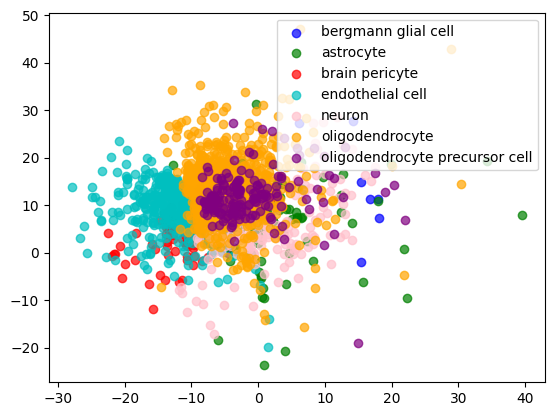

In [114]:
latent = np.load(f'data/{dataset_name}/RTD AutoEncoder H1_output_{version}.npy')
labels = np.load(f'data/{dataset_name}/RTD AutoEncoder H1_labels_{version}.npy')
colors = ['b', 'g', 'r', 'c', 'pink', 'orange', 'purple']

for i in range(7):
    points = latent[labels == i]
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], cmap='viridis', alpha = .7, label = cat2class[i])
plt.legend()

In [103]:
test_loader = DataLoader(
    test, 
    batch_size=config["batch_size"], 
    num_workers=2, 
    collate_fn=collate_with_matrix_geodesic if geodesic else collate_with_matrix, 
    shuffle=False
)

for model_name in trained_models:
    latent, labels = get_latent_representations(trained_models[model_name], test_loader)
    np.save(f'data/{dataset_name}/{model_name}_output_{version}_test.npy', latent)
    np.save(f'data/{dataset_name}/{model_name}_labels_{version}_test.npy', labels)

/tmp/ipykernel_624789/3311376334.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(points[:, 0], points[:, 1], c=colors[i], cmap='viridis', label = cat2class[i])


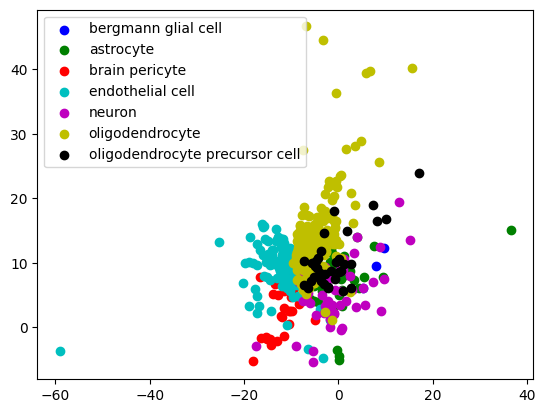

In [105]:
latent = np.load(f'data/{dataset_name}/RTD AutoEncoder H1_output_{version}_test.npy')
labels = np.load(f'data/{dataset_name}/RTD AutoEncoder H1_labels_{version}_test.npy')
for i in range(7):
    points = latent[labels == i]
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], cmap='viridis', label = cat2class[i])
plt.legend()

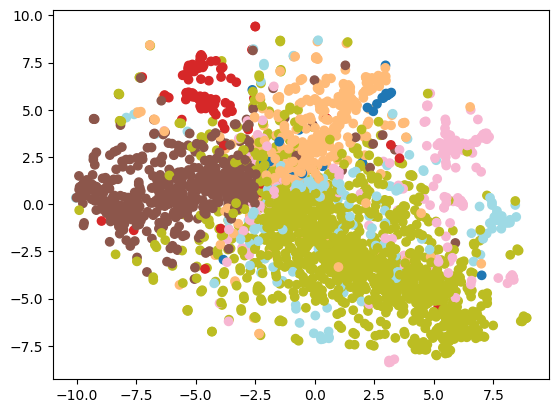

In [107]:
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(train_data)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=train_labels, cmap='tab20')

/users/eleves-b/2021/pierre.aguie/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/users/eleves-b/2021/pierre.aguie/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


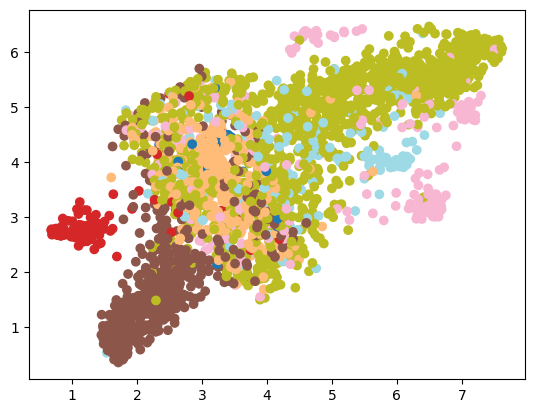

In [62]:
import umap

umap_model = umap.UMAP(n_components=2, random_state=42)
X_embedded = umap_model.fit_transform(train_data)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=train_labels, cmap='tab20')

## Metrics

In [ ]:
from src.rtd import RTDLoss
import torch

n_runs = 1
batch_size = 200

loss = RTDLoss(dim=1, engine='ripser')

data = train_data
data = data.reshape(len(data), -1)

latent_path = 'data/TabulaMuris/latent/RTD AutoEncoder H1_output_test_2.npy'

if batch_size > len(data):
    n_runs=1
    
max_dim = 1
results = []

for i in tqdm(range(n_runs)):
    ids = np.random.choice(np.arange(0, len(data)), size=min(batch_size, len(data)), replace=False)
    
    x = data[ids]
    x_distances = distance_matrix(x, x)
    x_distances = x_distances/np.percentile(x_distances.flatten(), 90)
    
    z = np.load(latent_path)
    z = z.reshape(len(z), -1)[ids]
    z_distances = distance_matrix(z, z)
    z_distances = z_distances/np.percentile(z_distances.flatten(), 90)
    print(f'Calculating RTD for: {model_name}')
    with torch.no_grad():
        _, _, value = loss(torch.tensor(x_distances), torch.tensor(z_distances))
    results[model_name].append(value.item())